## Analyze A/B Test Results:

## Table of Contents:
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction:

For this project, we will be working to understand the results of an A/B test run by an e-commerce website. The company has developed a new web page in order to try and increase the number of users who "convert," meaning the number of users who decide to pay for the company's product. <br><br>
Our goal is to work through this notebook to help the company understand if they should implement this new page, keep the old page, or perhaps run the experiment longer to make their decision. 

<a id='probability'></a>
### Part I - Probability:

To get started, let's import our libraries.

In [2]:
# load libraries
import pandas as pd
import numpy as np
import statsmodels.api as sm
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
np.random.seed(42)

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Now, let's read in the `ab_data.csv` data and take a look at the top few rows after storing it in `df`.  


In [3]:
# display the dataset
df = pd.read_csv('ab_data.csv')
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

Next, we are going to use the cell below to find the number of rows in the dataset, the number of unique users in the dataset, and the proportion of users converted.

In [4]:
# the number of rows in the dataset
df.shape[0]

294478

In [5]:
# the number of unique users in the dataset
df.user_id.nunique()

290584

In [6]:
# the proportion of users converted
df.converted.mean()

0.11965919355605512

Let's find the number of times the `new_page` and `treatment` don't match.

In [7]:
# display the number of times there is mismatch
df.query('group == "control" and landing_page == "new_page" or group == "treatment" and landing_page == "old_page"').user_id.count()

3893

Check if there are any missing values.

In [8]:
# check for missing values
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

We conclude that no row has missing values.

For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. So, we should only use the rows that we can feel confident in the accuracy of the data.

Now as we droped the rows that represents mismatch, let's create a new dataset called **df2** that meets the specifications, which contains only the rows where their respective columns group and landing_page are aligned. 

In [9]:
# Create a new dataframe that meets the specification of matching
df2 = df.query('group == "control" and landing_page == "old_page" or group == "treatment" and landing_page == "new_page"')

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

We are going to use **df2**:
- to count the number of unique user_id
- to check for duplicates
- to display which row information for the repeat user_id
- and finally, to remove one of the rows with a duplicate user_id 

In [11]:
# display the number of unique user_id 
df2['user_id'].nunique()

290584

In [12]:
# check for duplicated user_id
df2[df2['user_id'].duplicated()]['user_id'].sum()

773192

In [13]:
# view which rows have the same user_id of 773192
df2[df2['user_id'] == 773192]

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

In [14]:
# drop duplicates
df2.drop(2893, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
# Confirm correction by rechecking for duplicates in the data
df2[df2['user_id'] == 773192]

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0

The number of unique ids in df2 is 290584 while the user_id for the non-unique id in df2 that was repeated in two different rows is 773192.

Since, there is consistency with this user_id, we have chosen to remove one of them because we shouldn't be counting the same user more than once.

Now, we are going to use **df2** in the cells below to calculate:
- The probability of an individual converting regardless of the page they receive.
- The probability they converted assuming that an individual was in the control group.
- The probability they converted assuming that an individual was in the treatement group.
- Finally, the probability that an individual received the new page.


In [16]:
# display the probability of converting regardless of page
df2.converted.mean()

0.11959708724499628

In [17]:
# display the probability of converting given group equal control
df2[df2['group'] == 'control'].converted.mean()

0.1203863045004612

In [18]:
# display the probability of converting given group equal treatment
df2[df2['group'] == 'treatment'].converted.mean()

0.11880806551510564

In [19]:
# display the probability of receiving the new page
len(df2.query("landing_page == 'new_page'")) / df2.shape[0]

0.5000619442226688

Considering the results from above as follows:
- The probability of converting regardless of page is 0.1196
- Given that an individual was in the control group, the probability of converting is 0.1204
- Given that an individual was in the treatment group, the probability of converting is 0.1188
- The probability of receiving the new page is 0.5001

We can conclude that the conversion rate of the control group is slightly higher than the treatment group and the difference between them is insignificant. In addition, despite the probability that an individual received a new page is 0.50, it doesn't explain that there is sufficient evidence to conclude that the new treatment page contributes to more conversions of the users.


<a id='ab_test'></a>
### Part II - A/B Test:

Notice that because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do we have to stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do we have to run the A/B test to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


For now, we consider that we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  We can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

When performing hypothesis testing, the first thing we need to do is to translate a question into 2 competing hypotheses. One of these hypotheses is called the Null **H0**, and the other is called the Alternative **Ha**. 

**Pnew** represents the converted rate return for the new page. Similarly, **Pold** represents the converted rate return for the old page.

Because we wanted to test if the new page was better than the old page, we are going to set that up in the alternative hypothesis. Therefore, our hypothesis testing would look like this:

   **H0 : Pnew  ≤ Pold     vs.    Ha : Pnew  > Pold**

Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

In this case, we are testing simply if the converted success rate for the old and new page are the same or if they are different. 

We are going to use a sample size for each page equal to the ones in **ab_data.csv**, and then perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null. The following questions will help us to conduct our A/B testing: 
- What is the conversion rate for Pnew under the null?
- What is the conversion rate for Pold under the null?
- What is nnew, the number of individuals in the treatment group?
- What is nold, the number of individuals in the control group?
- Find the difference between Pnew and Pold for your simulated values?


In [20]:
# The conversion rate for P𝑛𝑒𝑤 under the null
p_new = df2['converted'].mean()
p_new

0.11959708724499628

In [21]:
# The conversion rate for Pold under the null
p_old = p_new = df2['converted'].mean()
p_old

0.11959708724499628

In [22]:
# The number of individuals in the treatment group
n_new = len(df2[df2['group'] == 'treatment'])
n_new

145310

In [23]:
# The number of individuals in the control group
n_old = len(df2[df2['group'] == 'control'])
n_old

145274

Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null. Then, store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
# Simulate the distribution under the null hypothesis
new_page_converted = np.random.choice([0,1], size = n_new, p =[(1-p_new), p_new])
new_page_converted

array([0, 1, 0, ..., 0, 0, 0])

Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null. Then, store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
# Simulate the distribution under the null hypothesis
old_page_converted = np.random.choice([0,1], size = n_old, p =[(1-p_old), p_old])
old_page_converted

array([0, 0, 0, ..., 0, 0, 1])

Now, we are going to calculate the observed difference between the treatment converted and control converted. Find Pnew - Pold for the simulated values 

In [26]:
# Compute the observed difference between Pnew and Pold
obs_diffs = df2.query('group == "treatment"').converted.mean() - df2.query('group == "control"').converted.mean()
obs_diffs

-0.0015782389853555567

Based on above, the difference is zero. We have been looking at a null hypothesis where there is no difference in conversion rates based on the page, which means the conversions for each page are the same in **ab_data.csv**.

Let's simulate the sampling distribution for the difference with bootstrapping, to see if the difference between new page and old page is significant. For this reason, we are going to create 10,000 Pnew - Pold values using the same simulation process we used above, and then store all 10,000 values in a NumPy array called **p_diffs**.

In [27]:
# Create a sampling distribution of the difference between Pnew and Pold
# with bootstrapping
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice([0,1], size = n_new, p=[(1-p_new), p_new])
    old_page_converted = np.random.choice([0,1], size = n_old, p=[(1-p_old), p_old])
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

After having simulated the sampling distribution for the difference , our next step is to plot a histogram of the p_diffs . 


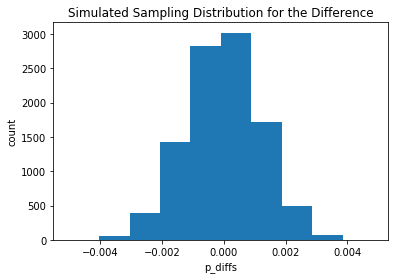

In [28]:
# Convert to numpy array
p_diffs = np.array(p_diffs)
# Plot a histogram of the p_diffs
plt.hist(p_diffs);
plt.title('Simulated Sampling Distribution for the Difference')
plt.xlabel('p_diffs')
plt.ylabel('count');

Our sampling distribution looks like a normal distribution centered at zero.
We can say that each of the simulated draws of the p_diffs in this sampling distribution represents a possible mean from the null hypothesis. 

In [29]:
# Plot the observed statistic
plt.hist(p_diffs)
plt.title('Simulated Sampling Distribution for the Difference')
plt.xlabel('p_diffs')
plt.ylabel('count')
plt.axvline(x = obs_diffs, c = 'red', linewidth = 2);

Based on the plot, we could see the null distribution and where the observed statistic falls on the above histogram. So, the observed statistic falls in **the left side** of our distribution as depicted by the red line. That's means, Pnew is lower than Pold in the null hypothesis which will be confirmed when we compute the p value.

Next, we are going to compute the p value for our statistic which is the proportion of the p_diffs that are greater than the actual difference observed in ab_data.csv.

In [30]:
# Compute the p value
(p_diffs > obs_diffs).mean()

0.90100000000000002

**p value is equal to 0.90 while alpha level is 0.05(5%)**<br><br>
**By comparing our p value to the type I error threshold alpha, we have evidence that our statistic comes from the null hypothesis. Therefore, we can make the decision that the null hypothesis shouldn't be rejected and conclude that the difference between the values of the new page and old page is not significantly different than the value of the null hypothesis.** <br><br>
**Based on these results, the e-commerce shouldn't implement the new page but it should keep the old page, or perhaps use a built-in to see if she can achieve similar results and then make its final decision.**

We are going to use a built-in test to check if we achieve similar results. for this reason, we have to calculate the number of conversions for each page, as well as the number of individuals who received each page. 
Let **n_old** and **n_new** refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
# load statsmodels library
import statsmodels.api as sm

# Create dataframes and compute values 
convert_old = df2.query('landing_page == "old_page" and converted == 1').shape[0]
convert_new = df2.query('landing_page == "new_page" and converted == 1').shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query('landing_page == "new_page"').shape[0]
convert_old, convert_new, n_old, n_new

(17489, 17264, 145274, 145310)

We conclude that the number of conversions for each page are the same.

Now, we use **stats.proportions_ztest** to compute the value z-test statistic and p-value.  

In [32]:
# Compute the value of z test and p value 
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

Let's calculate the critical value of the z test for the conversion rates of the old and new pages and compare it with its statistic value computed previously, which is 1.31.

In [33]:
# load scipy stats libraries
from scipy.stats import norm

# Check the significance of z score for a cumulative distribution function
# Display the critical value of z test at 95% confidence interval
norm.cdf(z_score), norm.ppf(1 - 0.05)

(0.90505831275902449, 1.6448536269514722)

**Based on above, we conclude that the p value that was computed previously is the same which agrees with the decision of the company to keep the old page.
z test confirms the finding as z statistic value (1.31) < z critical value (1.64), which means that we shouldn't reject the null hypothesis and conclude that the values of old page and new page are not singnificantly different from the value of the null at the specified 5% significance level of alpha.**

<a id='regression'></a>
### Part III - A regression approach:

In this final part, we will see if the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

Since each row is either a conversion or no conversion, which is only two possible outcomes, the type of regression that we should be performing in this case is the **logistic regression**.<br><br>

The goal is to use **statsmodels** to fit the **logistic regression model** and then to see if there is a significant difference in conversion based on which page a customer receives. However, our first need is to create in df2 a column for the intercept, and then create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
# Create a column for the intercept
df2['intercept'] = 1

# Create a dummy variable column
df2[['treatment','ab_page']] = pd.get_dummies(df2['group'])

# drop treatment from group
df2 = df2.drop('treatment', axis = 1)

df2.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  ab_page  
0          1        0  
1          1        0  
2          1        1  
3          1        1  
4          1        0

Now that we have our dummy variables, we will use **statsmodels** to import the regression model. Then, Instantiate the model, and fit the model using the two columns we already created in order to predict whether or not an individual converts.

In [36]:
# Create our logistic regression model 
df['intercept'] = 1
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


After the logistic regression model is fit to predict whether or not an individual converts from the old page to the new one, we are going to provide the summary of the model.

In [37]:
# Display logit regression results
from scipy import stats
stats.chisqprob = lambda chisq, df:stats.chi2.sf(chisq,df)
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 08 Feb 2021   Pseudo R-squ.:               8.077e-06
Time:                        05:31:08   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

Now that we have our logistic regression model, let's set up the associated null and alternative hypotheses:

   **H0 : Pnew = Pold vs. Ha : Pnew ≠ Pold**


Our alternative hypothesis **Ha** is what we want to prove to be true, in this case an individual is willing to convert from the old page to the new one. While, our null hypothesis **H0** is what we assume to be true before analysing the dataset, which means that the converted success rate from the old and new page are the same.

Compared to the null and alternative hypotheses in **Part II** which is a **one-tailed test**, and as we care only about statistics that are far from the null hypothesis in either direction of the distribution, we have to conduct in **Part III** a **two-tailed test** and compute the p value by determining the statistical significance of our observed difference.

**p value obtained from Part II is 0.90, while in Part III, p value of ab_page is 0.19 which greater than half of the significance level (1/2 alpha = 0.05/2 = 0.025), that's means that the explanatory variable (ab_page) is not statistically significant in predicting whether or not an individual converts.**

Now, we are considering other things that might influence whether or not an individual converts. 

**Adding other factors or features into our logistic regression model might improve our model and give us sigificant results. These factors could be the age of the user, the gender, the country or may be the time spent navigating the page. <br><br>
However, there's a number of problems that may arise when conducting z-tests which might become too small and less powerful and then lead to *Multicollinearity*. For example, a low z-test on an explanatory variable increases the chances of *Type II errors* which means failure to reject the null hypothesis when it is false. So to correct for Multicollinearity, we should exclude one or more of the independent variables from the regression model. Therefore, in our analysis, we have to add only the factors that are the most predictor**.

Now that along with testing if the conversion rate changes for different pages, we are going to add an effect based on which country a user lives in. For this reason, we are going to add the **countries.csv** dataset and merge together both datasets on the appropriate rows. 

In [38]:
# View the dataset
df3 = pd.read_csv('countries.csv')
df3.head()

user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK

In [39]:
# Display the number of users in each country
df3['country'].astype(str).value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [40]:
# Create a column for the intercept
df['intercept'] = 1

# Create dummy variables for country column
df3[['CA', 'UK', 'US']] = pd.get_dummies(df3['country'])

# drop the country column
df3 = df3.drop('CA', axis = 1)

df3.head()

user_id country  UK  US
0   834778      UK   1   0
1   928468      US   0   1
2   822059      UK   1   0
3   711597      UK   1   0
4   710616      UK   1   0

In [41]:
# Merge both datasets ab_data.csv and countries.csv into a new one
new_df = df2.join(df3.set_index('user_id'), on = 'user_id')
new_df.head()

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0   
4   864975  2017-01-21 01:52:26.210827    control     old_page          1   

   intercept  ab_page country  UK  US  
0          1        0      US   0   1  
1          1        0      US   0   1  
2          1        1      US   0   1  
3          1        1      US   0   1  
4          1        0      US   0   1

In [42]:
# View the mean of each country
new_df.query('US == 1').converted.mean(), new_df.query('UK == 1').converted.mean()

(0.1195468006423762, 0.12059448568984076)

Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion. Then we should create the necessary additional columns, and fit the new model, as well provide the summary results, and conclusions based on the results.

In [43]:
# Create new variables to analyze interaction between variables
new_df['US_ab_page'] = new_df['US'] * new_df['ab_page']
new_df['UK_ab_page'] = new_df['UK'] * new_df['ab_page']

In [45]:
# Fit the logit Regression Model
new_df['intercept'] = 1
log_mod1 = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page','US', 'UK']])
log_mod2 = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'UK', 'US', 'UK_ab_page', 'US_ab_page']])
results1 = log_mod1.fit()
results2 = log_mod2.fit()
results1.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212781.1253
Date:               2021-02-08 05:31 BIC:              212823.4439
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           3                LL-Null:          -1.0639e+05
Df Residuals:       290580           LLR p-value:      0.17599    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0300    0.0266  -76.2488  0.0000  -2.0822  -1.9778
ab_page       -0.0149    0.0114   -1.3069  0.1912  -0.0374   0.0075
US             0.0408    0.0269    1.5161  0.1295  -0.0119   0.0934
UK             0.0506    0.0284    1.7835  0.0745  -0.0050   0.1063
==================================================================

"""

In [47]:
# Display the results summary
results2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            Pseudo R-squared: 0.000      
Dependent Variable: converted        AIC:              212782.6602
Date:               2021-02-08 05:34 BIC:              212846.1381
No. Observations:   290584           Log-Likelihood:   -1.0639e+05
Df Model:           5                LL-Null:          -1.0639e+05
Df Residuals:       290578           LLR p-value:      0.19199    
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0040    0.0364  -55.0077  0.0000  -2.0754  -1.9326
ab_page       -0.0674    0.0520   -1.2967  0.1947  -0.1694   0.0345
UK             0.0118    0.0398    0.2957  0.7674  -0.0663   0.0899
US             0.0175    0.0377    0.4652  0.6418  -0.0563   0.0914
UK_ab_page     0.0783    0.0568    1.3783  0.1681  -0.0330   0.1896
US_ab_page     0.0469    0.0538    0.8718  0.3833  -0.0585   0.1523
==================================================================

"""

Notice that all the p values associated to the explanatory variables are not statistically significants in predicting if there is success in the conversion changes for differents pages. So, the interaction between ab_page with both dummy variables don't lead to significant effects on the conversion sucess rate. 

As we don't have sufficient evidence in favor of the conversion to the new page, it better for the e-commerce company to keep the old page as found in the the Part I and Part II and maybe add other factors and run the test again.


To conclude our analysis, let go ahead and check some statistics.

It is worth nothing that we need to exponentiate the regression coefficients (intercept and slope coefficient) before we can interpret them in logistic regression. Added to that, with returned values less than 1, it is often better to obtain their reciprocal.

In [48]:
np.exp(results.params)

intercept    0.136863
ab_page      0.985123
dtype: float64

In [49]:
1/np.exp(0.0408), 1/np.exp(0.0506)

(0.96002111497165088, 0.95065885803307093)

We could say that for every one unit decrease in the user for each country, conversion rate is respectively around 0.96 times for the users from USA and 0.95 times for the users from UK holding all else constant.

In [50]:
new_df.groupby(['US', 'UK']).converted.mean()

US  UK
0   0     0.115318
    1     0.120594
1   0     0.119547
Name: converted, dtype: float64

In [51]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0